# IMPORTS

In [1]:
import pandas as pd
import os
import time
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")

# Data processing

## Downloading Data

In [2]:
x_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
defo = list(y_train.target)
x_train['y'] = defo
x_train = x_train[~(x_train.age == 0)]
x_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,0


## Feature engineering

In [3]:
des = x_train.describe()
des = des.append(pd.Series(data={ _:np.sum(np.isnan(x_train[_])) for _ in x_train.columns}, name='nans'), ignore_index= False)
des

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
count,105108.000000,105108.000000,105108.000000,105108.000000,8.411500e+04,105108.000000,105108.000000,105108.000000,105108.000000,102303.000000,105108.000000
mean,5.825221,53.321574,0.426637,354.191521,6.649734e+03,8.956283,0.269970,1.018505,0.244358,0.757084,0.066893
std,251.022624,14.810164,4.251245,1827.192531,1.106510e+04,5.182731,4.227386,1.136230,4.214038,1.116524,0.249838
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029591,42.000000,0.000000,0.173668,3.343188e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153790,53.000000,0.000000,0.365038,5.361671e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.554344,64.000000,0.000000,0.880885,8.207870e+03,12.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,48779.730023,111.000000,98.000000,323248.210242,1.359526e+06,58.000000,98.000000,54.000000,98.000000,20.000000,1.000000
nans,0.000000,0.000000,0.000000,0.000000,2.099300e+04,0.000000,0.000000,0.000000,0.000000,2805.000000,0.000000


We can see that columns 'monthly_income' and 'family_members' has lots of nan's in it, so we should replace them. 

In [4]:
crm = x_train.corr()
fig = px.imshow(crm)
fig.update_layout(paper_bgcolor="rgb(1,1,1,1)", font_color = "rgb(255, 255, 255)")
fig.show()

From the correlation matrix we can see that family members have correlation with age.

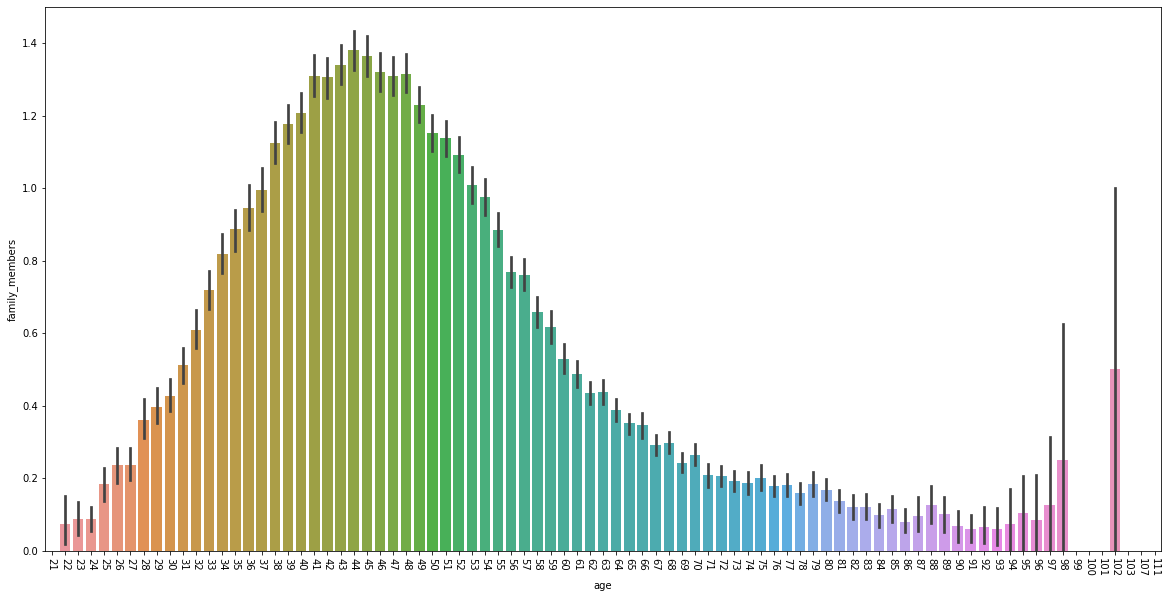

In [5]:
plt.figure(figsize=[20,10])
plt.ylim(0, 1.5)
ax1 = sns.barplot("age", "family_members", data=x_train)
ax2 = ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-90)

As we can see, the relationship between these variables, we can replace nan's with average family members for people of this age, rather than replace it with a simple mean value from the whole dataset.

In [6]:
for i in range(len(x_train.family_members)):
    if np.isnan(x_train.family_members.iloc[i]):
        x_train.family_members.loc[i] = np.mean(x_train.family_members[x_train.age == x_train.age.loc[i]])
x_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,0


Also, from the correlation matrix, we can see that monthly income correlates with mortgage loans and credit loans, so we can make a regression that will predict monthly income in missing points. 

In [7]:
to_dro = ['credit_card_utilization', 'age', 'overdue_30_59_days', 'debt_to_income', 'monthly_income', 'overdue__more_than_90_days', 'family_members', 'overdue_60_89_days', 'y']
X = x_train.dropna().drop(columns=to_dro)
y = x_train.dropna()['monthly_income']
reg = sm.OLS(y, sm.add_constant(X)).fit()
x_train_cp = x_train[x_train.monthly_income.isna()]
pred = reg.predict(sm.add_constant(x_train_cp.drop(columns=to_dro)))
j = 0
for i in range(len(x_train.monthly_income)):
    if np.isnan(x_train.monthly_income.iloc[i]):
        x_train.monthly_income.loc[i] = pred.iloc[j]
        j+=1

Again using the correlation matrix we can see a high correlation between three overdue columns. To avoid multicollinearity we can sum all these columns with coefficients 1,2,3 (more days of overdue - larger coefficient).

Also, we can deal with family members. This variable seems to be useless on its own, but we can try to divide monthly income by it. 

Further, we can deal with debt/income. As we already have a monthly income in the columns, then to avoid multicollinearity we can multiply monthly income by debt/income to have net debt in columns. 

In [8]:
if 'debt' not in x_train.columns:
    x_train['debt'] = x_train.debt_to_income * x_train.monthly_income
    x_train.drop(columns=['debt_to_income'], inplace=True)

if 'overdue_30_59_days' in x_train.columns:
    x_train['overdue'] = 0
    x_train['overdue'] += x_train['overdue_30_59_days']
    x_train['overdue'] += x_train['overdue_60_89_days']*2
    x_train['overdue'] += x_train['overdue__more_than_90_days']*3

if 'overdue_30_59_days' in x_train.columns:
    x_train.drop(columns=['overdue_30_59_days', 'overdue_60_89_days', 'overdue__more_than_90_days'], inplace=True)

if 'family_members' in x_train.columns:
    x_train['monthly_income'] = x_train['monthly_income']/(x_train['family_members']+1)
    x_train.drop(columns=['family_members'], inplace=True)

In [9]:
x_train.to_csv('train.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0365b271-6605-4524-ad1f-e00dd9a323c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>